# Urban Heat Island (UHI) Benchmark Notebook

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product.
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [ ]:
!pip install rioxarray geopandas rasterio pyproj pystac_client planetary_computer pystac

In [ ]:
!pip install --no-cache-dir pandas --upgrade pandas seaborn

In [ ]:
!pip freeze > requirements.txt

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

from shapely.geometry import Point, MultiPolygon, Polygon

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location.

<h10 style="color:rgb(255, 255, 0)"><strong>Note: Participants are strictly prohibited from using Longitude and Latitude values as features in building their machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations. Submissions that employ longitude and latitude values as model features will be disqualified.</strong></h10>

In [ ]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul>
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image.

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

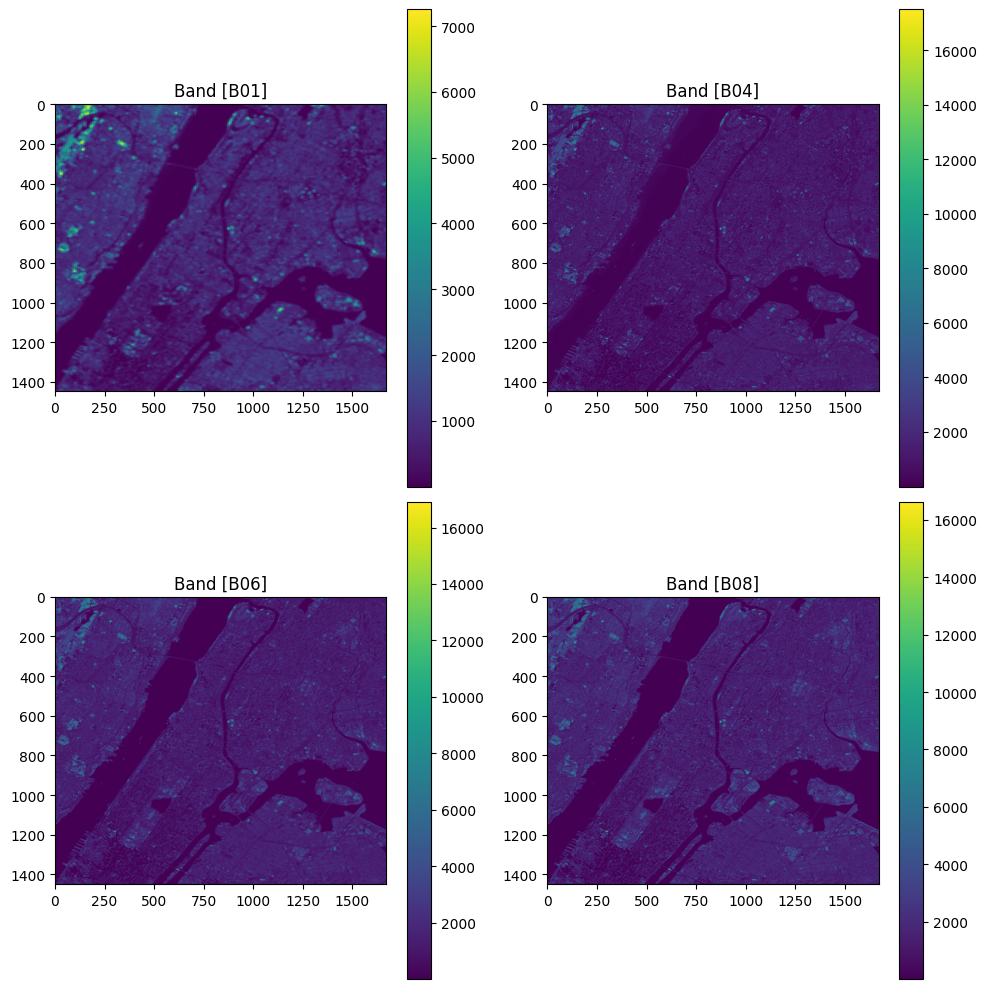

In [ ]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [ ]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B04_values = []
    B06_values = []
    B08_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)

        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)

        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)

        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)


    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    return df


In [ ]:
# Mapping satellite data with training data.
final_data = map_satellite_data('S2_sample.tiff', 'Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [00:49<00:00, 227.18it/s]


In [ ]:
final_data.head()

,B01,B04,B06,B08
0,502.0,775.0,948.0,844.0
1,502.0,775.0,948.0,844.0
2,502.0,1000.0,1123.0,1578.0
3,502.0,835.0,1123.0,1320.0
4,502.0,771.0,999.0,1080.0


In [ ]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [ ]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

## Extracting Land Satelllite Values from LandsatTiff

In [ ]:
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import xarray as xr


# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)


# Load Landsat LST raster
landsat_lst = rio.open_rasterio("Landsat_LST.tiff")

# Convert Landsat CRS to WGS84 (EPSG:4326) if needed
landsat_lst = landsat_lst.rio.reproject("EPSG:4326")

# Function to extract LST for given lat/lon
def extract_lst_values(df, lst_data):
    lst_values = []

    for _, row in df.iterrows():
        # print(row)
        lat, lon = row["Latitude"], row["Longitude"]

        # Extract LST using correct coordinate order
        lst_value = lst_data.sel(x=lon, y=lat, method="nearest").values
        # print(lst_value)
        # Ensure lst_value is a scalar, not an array
        if isinstance(lst_value, np.ndarray):
            lst_value = lst_value.item()  # Convert single-element array to a scalar

        lst_values.append(lst_value)

    df["Landsat_LST"] = lst_values
    return df

# Apply the function
uhi_data = extract_lst_values(uhi_data, landsat_lst)
uhi_data.head()
lst_celsius = uhi_data["Landsat_LST"]

In [ ]:
lst_mean = np.nanmean(lst_celsius)  # Compute city-wide mean
lst_anomaly = lst_celsius - lst_mean  # Subtract mean
lst_scaled = np.maximum(lst_anomaly, 0)
# Ensure lst_scaled is a NumPy array
lst_scaled = np.array(lst_scaled, dtype=float)

# Apply log scaling
lst_scaled = np.log1p(lst_scaled)  # log(1 + x) to avoid log(0)

In [ ]:
lst_scaled
uhi_data["lst_anomaly"] = lst_scaled

In [ ]:
max(uhi_data["lst_anomaly"])

2.386982869102501

In [ ]:
from scipy.spatial import KDTree

coords = uhi_data[["Longitude", "Latitude"]].values

tree = KDTree(coords)

# Compute LST anomaly gradient (difference with nearest neighbor)
gradients = []
for i, (lon, lat) in enumerate(coords):
    _, idx = tree.query([lon, lat], k=5)  # Find 5 nearest neighbors
    neighbor_values = lst_scaled[idx]
    gradient = np.mean(np.abs(lst_scaled[i] - neighbor_values))  # Average difference
    gradients.append(gradient)

# Store the result
uhi_data["LST_Gradient"] = gradients

In [ ]:
uhi_data

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,NDVI,Landsat_LST,lst_anomaly,LST_Gradient
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,502.0,775.0,948.0,844.0,0.042619,38.393941,0.913405,0.219307
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,502.0,775.0,948.0,844.0,0.042619,38.393941,0.913405,0.219307
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,502.0,1000.0,1123.0,1578.0,0.224205,37.785534,0.633603,0.163347
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,502.0,835.0,1123.0,1320.0,0.225058,37.785534,0.633603,0.158813
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,502.0,771.0,999.0,1080.0,0.166937,37.358281,0.376472,0.102852
...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,1189.0,1092.0,1816.0,2192.0,0.334957,30.293234,0.000000,0.000000
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,1189.0,1268.0,1816.0,2754.0,0.369468,30.293234,0.000000,0.000000
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,1189.0,1268.0,1816.0,2754.0,0.369468,30.440209,0.000000,0.000000
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,1189.0,1268.0,1816.0,2754.0,0.369468,30.440209,0.000000,0.000000


## Extracting Features from Building Footprint

In [ ]:
building_footprint = gpd.read_file('Building_Footprint.kml')
building_footprint.head()

,Name,Description,geometry
0,,,"MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4..."
1,,,"MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ..."
2,,,"MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4..."
3,,,"MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4..."
4,,,"MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ..."


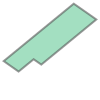

In [ ]:
building_footprint['geometry'][0]

In [ ]:
building_footprint['area'] = building_footprint['geometry'].area
building_footprint.head()

,Name,Description,geometry,area
0,,,"MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...",6.621750e-08
1,,,"MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...",1.017900e-08
2,,,"MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...",1.509400e-08
3,,,"MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...",8.512000e-09
4,,,"MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...",2.309100e-08


In [ ]:
# 1. Extract lat and lon from building footprint
def extract_centroid_coords(geom):
    centroid = geom.centroid
    return centroid.x, centroid.y  # Longitude, Latitude

building_footprint[['Longitude', 'Latitude']] = building_footprint.apply(
    lambda row: pd.Series(extract_centroid_coords(row['geometry'])), axis=1)

# 2. Convert uhi_data to GeoDataFrame
uhi_gdf = gpd.GeoDataFrame(
    uhi_data,
    geometry=gpd.points_from_xy(uhi_data.Longitude, uhi_data.Latitude),
    crs="EPSG:4326"
)

from sklearn.neighbors import NearestNeighbors

# Create NearestNeighbors model for building footprint
nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(building_footprint[['Longitude', 'Latitude']])

# Find nearest building for each UHI point
distances, indices = nn_model.kneighbors(uhi_gdf[['Longitude', 'Latitude']])

# Add building footprint data to uhi_gdf
uhi_gdf['building_area'] = building_footprint.loc[indices.flatten(), 'area'].values

In [ ]:
median_building_area = uhi_gdf['building_area'].median()
characteristic_length = np.sqrt(median_building_area)

# Define a new reasonable search radius (5× characteristic length)
new_radius = 5 * characteristic_length
new_radius

np.float64(0.0019149673626272456)

In [ ]:
# Initialize the new feature column
uhi_gdf["building_density"] = np.nan

# Compute building density with a progress bar
for index in tqdm(range(len(uhi_gdf)), desc="Calculating Building Density"):
    point = uhi_gdf.loc[index, "geometry"]
    uhi_gdf.loc[index, "building_density"] = sum(uhi_gdf.distance(point) < new_radius)

# Convert to numeric type
uhi_gdf["building_density"] = uhi_gdf["building_density"].astype(int)

Calculating Building Density: 100%|██████████| 11229/11229 [04:57<00:00, 37.76it/s]


In [ ]:
uhi_gdf.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,NDVI,Landsat_LST,lst_anomaly,LST_Gradient,geometry,building_area,building_density,building_density_log,PCA_1,PCA_2
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,502.0,775.0,948.0,844.0,0.042619,38.393941,0.913405,0.219307,POINT (-73.90917 40.81311),2.501250e-08,29,3.401197,-734.055916,-41.136640
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,502.0,775.0,948.0,844.0,0.042619,38.393941,0.913405,0.219307,POINT (-73.90919 40.81304),2.501250e-08,30,3.433987,-734.055916,-41.136640
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,502.0,1000.0,1123.0,1578.0,0.224205,37.785534,0.633603,0.163347,POINT (-73.90922 40.81298),6.599775e-07,32,3.496508,-48.447139,-251.574512
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,502.0,835.0,1123.0,1320.0,0.225058,37.785534,0.633603,0.158813,POINT (-73.90924 40.81291),6.599775e-07,33,3.526361,-310.205311,-122.662366
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,502.0,771.0,999.0,1080.0,0.166937,37.358281,0.376472,0.102852,POINT (-73.90926 40.81284),6.599775e-07,34,3.555348,-560.772056,-93.177851


In [ ]:
uhi_gdf["building_density_log"] = np.log1p(uhi_gdf["building_density"])

## PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
uhi_gdf_pca = pca.fit_transform(uhi_gdf[['B01', 'B06', 'B04', 'B08']])
uhi_gdf['PCA_1'] = uhi_gdf_pca[:, 0]
uhi_gdf['PCA_2'] = uhi_gdf_pca[:, 1]

In [ ]:
uhi_gdf.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,NDVI,Landsat_LST,lst_anomaly,LST_Gradient,geometry,building_area,building_density,building_density_log,PCA_1,PCA_2
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,502.0,775.0,948.0,844.0,0.042619,38.393941,0.913405,0.219307,POINT (-73.90917 40.81311),2.501250e-08,29,3.401197,-734.055916,-41.136640
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,502.0,775.0,948.0,844.0,0.042619,38.393941,0.913405,0.219307,POINT (-73.90919 40.81304),2.501250e-08,30,3.433987,-734.055916,-41.136640
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,502.0,1000.0,1123.0,1578.0,0.224205,37.785534,0.633603,0.163347,POINT (-73.90922 40.81298),6.599775e-07,32,3.496508,-48.447139,-251.574512
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,502.0,835.0,1123.0,1320.0,0.225058,37.785534,0.633603,0.158813,POINT (-73.90924 40.81291),6.599775e-07,33,3.526361,-310.205311,-122.662366
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,502.0,771.0,999.0,1080.0,0.166937,37.358281,0.376472,0.102852,POINT (-73.90926 40.81284),6.599775e-07,34,3.555348,-560.772056,-93.177851


In [ ]:
weather_df

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Latitude,Longitude,Altitude,datetime,hour
0,2021-07-24 06:00:00 EDT,19.3,88.2,0.8,335,12,40.87248,-73.89352,57.5,2021-07-24 06:00:00,6
169,2021-07-24 06:00:00 EDT,21.3,66.5,0.9,348,10,40.76754,-73.96449,94.8,2021-07-24 06:00:00,6
170,2021-07-24 06:05:00 EDT,21.4,66.1,1.1,345,12,40.76754,-73.96449,94.8,2021-07-24 06:05:00,6
1,2021-07-24 06:05:00 EDT,19.4,87.9,0.8,329,18,40.87248,-73.89352,57.5,2021-07-24 06:05:00,6
2,2021-07-24 06:10:00 EDT,19.3,87.6,0.7,321,25,40.87248,-73.89352,57.5,2021-07-24 06:10:00,6
...,...,...,...,...,...,...,...,...,...,...,...
166,2021-07-24 19:50:00 EDT,24.9,48.7,3.8,168,17,40.87248,-73.89352,57.5,2021-07-24 19:50:00,19
336,2021-07-24 19:55:00 EDT,24.8,48.0,2.0,182,18,40.76754,-73.96449,94.8,2021-07-24 19:55:00,19
167,2021-07-24 19:55:00 EDT,24.9,47.3,4.1,171,16,40.87248,-73.89352,57.5,2021-07-24 19:55:00,19
168,2021-07-24 20:00:00 EDT,24.9,47.4,3.6,162,13,40.87248,-73.89352,57.5,2021-07-24 20:00:00,20


## Extract useful features from Weather Data

#### Merge UHI Data with Weather Data

In [ ]:
import pandas as pd

# === Load Weather Data ===
excel_file = "NY_Mesonet_Weather.xlsx"
xls = pd.ExcelFile(excel_file)

# Load Bronx weather data and add location metadata
bronx_weather = pd.read_excel(xls, sheet_name="Bronx")
bronx_weather["Latitude"] = 40.87248
bronx_weather["Longitude"] = -73.89352
bronx_weather["Altitude"] = 57.5

# Load Manhattan weather data and add location metadata
manhattan_weather = pd.read_excel(xls, sheet_name="Manhattan")
manhattan_weather["Latitude"] = 40.76754
manhattan_weather["Longitude"] = -73.96449
manhattan_weather["Altitude"] = 94.8

# Combine the weather data from both sheets
weather_df = pd.concat([bronx_weather, manhattan_weather], ignore_index=True)

# Convert timestamp columns to datetime format
if 'Date / Time' in weather_df.columns:
    weather_df.rename(columns={'Date / Time': 'datetime'}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], errors="coerce")

# Extract the hour from datetime
weather_df['hour'] = weather_df['datetime'].dt.hour

# === Load UHI Data ===
# Assuming `uhi_gdf` is already loaded as a GeoDataFrame
if 'datetime' not in uhi_gdf.columns:
    raise ValueError("uhi_gdf is missing the 'datetime' column.")

uhi_gdf['datetime'] = pd.to_datetime(uhi_gdf['datetime'], format='%d-%m-%Y %H:%M', errors='coerce')

# Sort both DataFrames by datetime
uhi_gdf = uhi_gdf.sort_values("datetime")
weather_df = weather_df.sort_values("datetime")

# === Merge UHI Data with Weather Data ===
merged_df = pd.merge_asof(
    uhi_gdf, weather_df,
    on="datetime",  # Merge on closest datetime
    direction="nearest"  # Allow nearest match
)

# Debugging: Print dataset shapes and preview the merged dataset
print("Shape of UHI Data:", uhi_gdf.shape)
print("Shape of Weather Data:", weather_df.shape)
print("Shape of Merged Data:", merged_df.shape)

# Display preview of merged data
print("\nMerged Data Preview:")
print(merged_df.head())

Shape of UHI Data: (11229, 18)
Shape of Weather Data: (338, 10)
Shape of Merged Data: (11229, 27)

Merged Data Preview:
   Longitude_x  Latitude_x            datetime  UHI Index    B01     B04  \
0   -73.977157   40.771555 2021-07-24 15:01:00   0.975234  775.0  1324.0   
1   -73.909962   40.803688 2021-07-24 15:01:00   0.998554  773.0  1142.0   
2   -73.910167   40.803775 2021-07-24 15:01:00   1.000718  773.0  1222.0   
3   -73.910268   40.803817 2021-07-24 15:01:00   1.000718  773.0  1116.0   
4   -73.978742   40.771675 2021-07-24 15:01:00   0.975234  688.0   593.0   

      B06     B08      NDVI  Landsat_LST  ...      PCA_2  \
0  1599.0  1692.0  0.122016    31.639934  ...  90.227792   
1  1079.0  1112.0 -0.013310    39.347569  ...  44.605385   
2  1210.0  1388.0  0.063602    40.837825  ...   2.716994   
3  1210.0  1228.0  0.047782    40.837825  ...  83.554761   
4  1025.0  1174.0  0.328806    33.444648  ...  65.621411   

   Air Temp at Surface [degC] Relative Humidity [percent]  \
0

In [ ]:
column_mapping = {
    "Longitude_x": "Longitude",
    "Latitude_x": "Latitude",
    "Longitude_y": "Weather_Longitude",
    "Latitude_y": "Weather_Latitude"
}

merged_df.rename(columns=column_mapping, inplace=True)

uhi_data = merged_df

uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,NDVI,Landsat_LST,...,Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Weather_Latitude,Weather_Longitude,Altitude,hour,temp_gradient,humidity_temp_interaction
0,-73.977157,40.771555,2021-07-24 15:01:00,0.975234,775.0,1324.0,1599.0,1692.0,0.122016,31.639934,...,51.1,4.1,139,140,40.76754,-73.96449,94.8,15,5.539934,1333.71
1,-73.909962,40.803688,2021-07-24 15:01:00,0.998554,773.0,1142.0,1079.0,1112.0,-0.013310,39.347569,...,51.1,4.1,139,140,40.76754,-73.96449,94.8,15,13.247569,1333.71
2,-73.910167,40.803775,2021-07-24 15:01:00,1.000718,773.0,1222.0,1210.0,1388.0,0.063602,40.837825,...,51.1,4.1,139,140,40.76754,-73.96449,94.8,15,14.737825,1333.71
3,-73.910268,40.803817,2021-07-24 15:01:00,1.000718,773.0,1116.0,1210.0,1228.0,0.047782,40.837825,...,51.1,4.1,139,140,40.76754,-73.96449,94.8,15,14.737825,1333.71
4,-73.978742,40.771675,2021-07-24 15:01:00,0.975234,688.0,593.0,1025.0,1174.0,0.328806,33.444648,...,51.1,4.1,139,140,40.76754,-73.96449,94.8,15,7.344648,1333.71


#### Weather Feature Engineering

In [ ]:
uhi_data["temp_gradient"] = uhi_data["Landsat_LST"] - uhi_data["Air Temp at Surface [degC]"]
uhi_data["humidity_temp_interaction"] = uhi_data["Relative Humidity [percent]"] * uhi_data["Air Temp at Surface [degC]"]
uhi_data["wind_temp_interaction"] = uhi_data["Avg Wind Speed [m/s]"] * uhi_data["Air Temp at Surface [degC]"]

In [ ]:
uhi_data.shape

(11229, 30)

## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [ ]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01','B06','B08','NDVI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')

uhi_data=uhi_data.reset_index(drop=True)

uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,NDVI,Landsat_LST,...,Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Weather_Latitude,Weather_Longitude,Altitude,hour,temp_gradient,humidity_temp_interaction,wind_temp_interaction
0,-73.977157,40.771555,2021-07-24 15:01:00,0.975234,775.0,1324.0,1599.0,1692.0,0.122016,31.639934,...,4.1,139,140,40.76754,-73.96449,94.8,15,5.539934,1333.71,107.01
1,-73.909962,40.803688,2021-07-24 15:01:00,0.998554,773.0,1142.0,1079.0,1112.0,-0.013310,39.347569,...,4.1,139,140,40.76754,-73.96449,94.8,15,13.247569,1333.71,107.01
2,-73.910167,40.803775,2021-07-24 15:01:00,1.000718,773.0,1222.0,1210.0,1388.0,0.063602,40.837825,...,4.1,139,140,40.76754,-73.96449,94.8,15,14.737825,1333.71,107.01
3,-73.910268,40.803817,2021-07-24 15:01:00,1.000718,773.0,1116.0,1210.0,1228.0,0.047782,40.837825,...,4.1,139,140,40.76754,-73.96449,94.8,15,14.737825,1333.71,107.01
4,-73.978742,40.771675,2021-07-24 15:01:00,0.975234,688.0,593.0,1025.0,1174.0,0.328806,33.444648,...,4.1,139,140,40.76754,-73.96449,94.8,15,7.344648,1333.71,107.01


In [ ]:
uhi_data.shape

(8350, 30)

## Correlation Analysis

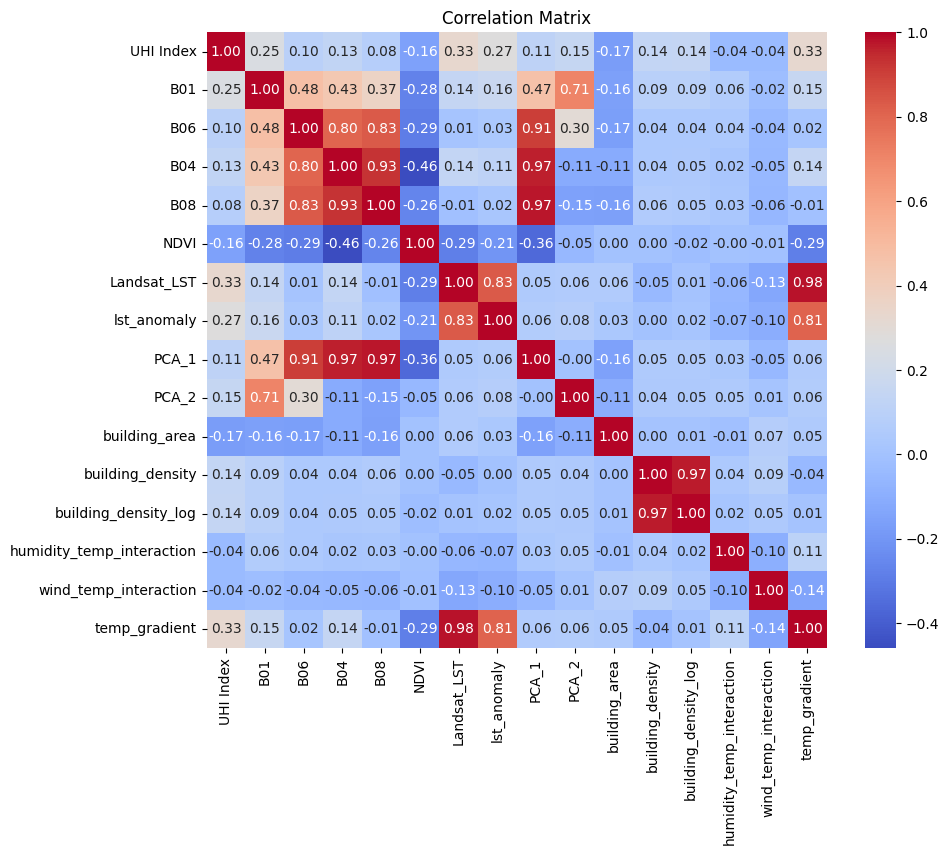

In [ ]:
columns_for_correlation = ['UHI Index', 'B01', 'B06', 'B04', 'B08', 'NDVI', 'Landsat_LST', 'lst_anomaly', 'PCA_1', 'PCA_2', 'building_area',
                           'building_density', 'building_density_log', 'humidity_temp_interaction', 'wind_temp_interaction', 'temp_gradient']

correlation_matrix = uhi_data[columns_for_correlation].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [ ]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.

# additionally use "wind speed", "direction", and "solar flux"
uhi_data_modified = uhi_data[['B01','B04','B08', 'UHI Index', 'Landsat_LST', 'lst_anomaly',
                              'building_density', 'building_density_log', 'temp_gradient']]

In [ ]:
uhi_data_modified.columns

Index(['B01', 'B04', 'B08', 'UHI Index', 'Landsat_LST', 'lst_anomaly',
       'building_density', 'building_density_log', 'temp_gradient'],
      dtype='object')

### Train and Test Split

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [ ]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data_modified.drop(columns=['UHI Index']).values
y = uhi_data_modified['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01,random_state=123)

### Feature Scaling

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [ ]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [ ]:
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [ ]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [ ]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9619546243728928

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now.

In [ ]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [ ]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.6611298484013265

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rio
from tqdm import tqdm
from sklearn.neighbors import KDTree, NearestNeighbors

def map_data(sentinel_tiff, landsat_tiff, csv_path, uhi_data):
    """
    Extracts Sentinel-2 features, Landsat LST values, and maps PCA_2 & building_density_log
    from UHI data for submission locations.

    Parameters:
        sentinel_tiff (str): Path to Sentinel-2 GeoTIFF file.
        landsat_tiff (str): Path to Landsat LST GeoTIFF file.
        csv_path (str): Path to submission CSV file.
        uhi_gdf (pd.DataFrame): DataFrame containing precomputed PCA_2 and building_density_log.

    Returns:
        pd.DataFrame: Submission dataset with Sentinel-2, Landsat LST, and mapped UHI data.
    """
    # Load the submission dataset
    submission_df = pd.read_csv(csv_path)

    # Load Sentinel-2 GeoTIFF data
    sentinel_data = rio.open_rasterio(sentinel_tiff)

    # Load Landsat LST data
    landsat_lst = rio.open_rasterio(landsat_tiff)

    # Extract coordinates
    latitudes = submission_df["Latitude"].values
    longitudes = submission_df["Longitude"].values

    # Initialize lists for extracted values
    B01_values, B04_values, B06_values, B08_values = [], [], [], []
    LST_values = []

    # Extract Sentinel-2 and Landsat LST values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Extracting Features"):
        try:
            # Sentinel-2 bands
            B01_values.append(sentinel_data.sel(x=lon, y=lat, band=1, method="nearest").values.item())
            B04_values.append(sentinel_data.sel(x=lon, y=lat, band=2, method="nearest").values.item())
            #B06_values.append(sentinel_data.sel(x=lon, y=lat, band=3, method="nearest").values.item())
            B08_values.append(sentinel_data.sel(x=lon, y=lat, band=4, method="nearest").values.item())

            # Landsat LST
            LST_values.append(landsat_lst.sel(x=lon, y=lat, method="nearest").values.item())

        except Exception as e:
            print(f"Error at ({lat}, {lon}): {e}")
            B01_values.append(None)
            B04_values.append(None)
            #B06_values.append(None)
            B08_values.append(None)
            LST_values.append(None)

    # Add extracted values to DataFrame
    submission_df["B01"] = B01_values
    submission_df["B04"] = B04_values
    #submission_df["B06"] = B06_values
    submission_df["B08"] = B08_values
    submission_df["Landsat_LST"] = LST_values

    # Compute lst_anomaly and apply log scaling
    lst_mean = np.nanmean(LST_values)
    lst_anomaly = np.array(LST_values) - lst_mean
    lst_scaled = np.maximum(lst_anomaly, 0)  # Ensure non-negative values
    lst_scaled = np.log1p(lst_scaled)  # Apply log(1 + x) scaling
    submission_df["lst_anomaly"] = lst_scaled

    # Compute LST Gradient using KDTree
    coords = submission_df[["Longitude", "Latitude"]].values
    tree = KDTree(coords)
    gradients = []
    for i, (lon, lat) in enumerate(coords):
        _, idx = tree.query(np.array([[lon, lat]]), k=5)  # Ensure input is 2D
        neighbor_values = lst_scaled[idx]
        gradient = np.mean(np.abs(lst_scaled[i] - neighbor_values))  # Average difference
        gradients.append(gradient)
    submission_df["LST_Gradient"] = gradients

    # **Mapping PCA_2 and building_density_log from UHI data**
    print("Mapping PCA_2 and building_density_log...")

    # Create NearestNeighbors model for UHI dataset
    nn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(uhi_data[['Longitude', 'Latitude']])

    # Find nearest UHI data point for each submission point
    distances, indices = nn_model.kneighbors(submission_df[['Longitude', 'Latitude']])

    # Assign mapped values
    #submission_df['PCA_2'] = uhi_data.loc[indices.flatten(), 'PCA_2'].values
    submission_df['building_density'] = uhi_data.loc[indices.flatten(), 'building_density'].values
    submission_df['building_density_log'] = uhi_data.loc[indices.flatten(), 'building_density_log'].values

    submission_df['temp_gradient'] = uhi_data.loc[indices.flatten(), 'temp_gradient'].values

    return submission_df

In [ ]:
# Mapping satellite data for submission.
val_data = map_data('S2_sample.tiff', "Landsat_LST.tiff", 'Submission_template.csv', uhi_data)

Extracting Features: 100%|██████████| 1040/1040 [00:04<00:00, 227.95it/s]


Mapping PCA_2 and building_density_log...


In [ ]:
max(val_data['lst_anomaly'])

2.3866462203569156

In [ ]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01', 'B04', 'B08', 'Landsat_LST','lst_anomaly', 'building_density', 'building_density_log','temp_gradient']]
submission_val_data.head()

,B01,B04,B08,Landsat_LST,lst_anomaly,building_density,building_density_log,temp_gradient
0,351.0,688.0,1062.0,36.202990,0.0,31,3.465736,8.902990
1,778.0,1136.0,2068.0,36.202990,0.0,37,3.637586,8.902990
2,251.0,64.0,139.0,36.069687,0.0,27,3.332205,8.969687
3,722.0,405.0,446.0,36.886594,0.0,42,3.761200,9.924978
4,419.0,392.0,731.0,34.500816,0.0,26,3.295837,7.581971


In [ ]:
# Feature Scaling
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [ ]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.962391
1,-73.971928,40.788875,0.980774
2,-73.967080,40.789080,0.956517
3,-73.972550,40.789082,0.990331
4,-73.969697,40.787953,0.962169


In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission12.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>